In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Using  2 GPUs!


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [6]:
import transformers

## Convert pt to pretrained bin

In [7]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/base_vqa/ofa_vqa.33000.pt"


In [8]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [9]:
# fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.32000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [10]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-base-vqa/')
vqa_model = OFAModelForVQA(ofa_config)

/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [12]:
unwrapped_model.load_state_dict(pkg['model'])

<All keys matched successfully>

In [13]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/ofa-base-vqa/', save_function=accelerator.save)

##  Weight transfer to transformer model

In [79]:
model_b = OFAModelForVQA.from_pretrained("OFA-base/", use_cache=False)


In [81]:
base = torch.load("OFA-base/pytorch_model.bin")

In [172]:
base_vqa = torch.load("vqa_base_best.pt")["model"]
del base_vqa["encoder.version"]
del base_vqa["decoder.version"]

In [173]:
def change_key(self, old, new):
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v

In [174]:
 my_dic_keys = list(base_vqa.keys())

In [175]:
for i in my_dic_keys:
#     print(i)
    if "ffn_layernorm" in i and "encoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
    if "attn_ln" in i and "encoder" in i:
        new = str(i).replace("attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
        
    if "encoder_attn" in i and "decoder" in i:
        new = str(i).replace("encoder_attn","cross_attn")
        change_key(base_vqa , i , new)
        
    if "ffn_layernorm" in i and "decoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "cross_attn_ln" in i and "decoder" in i:
        new = str(i).replace("cross_attn_ln","cross_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "self_attn_ln" in i and "decoder" in i:
        new = str(i).replace("self_attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 

encoder.layers.0.attn_ln.weight
encoder.layers.0.attn_ln.bias
encoder.layers.0.ffn_layernorm.weight
encoder.layers.0.ffn_layernorm.bias
encoder.layers.1.attn_ln.weight
encoder.layers.1.attn_ln.bias
encoder.layers.1.ffn_layernorm.weight
encoder.layers.1.ffn_layernorm.bias
encoder.layers.2.attn_ln.weight
encoder.layers.2.attn_ln.bias
encoder.layers.2.ffn_layernorm.weight
encoder.layers.2.ffn_layernorm.bias
encoder.layers.3.attn_ln.weight
encoder.layers.3.attn_ln.bias
encoder.layers.3.ffn_layernorm.weight
encoder.layers.3.ffn_layernorm.bias
encoder.layers.4.attn_ln.weight
encoder.layers.4.attn_ln.bias
encoder.layers.4.ffn_layernorm.weight
encoder.layers.4.ffn_layernorm.bias
encoder.layers.5.attn_ln.weight
encoder.layers.5.attn_ln.bias
encoder.layers.5.ffn_layernorm.weight
encoder.layers.5.ffn_layernorm.bias


In [176]:
mis = []
for i in (base_vqa.keys()):
    
    if i in base.keys():
        continue
    else:
        print(i)
        mis.append(i)

len(mis)

0

In [177]:
torch.save(base_vqa , "OFA-base-vqa/pytorch_model.bin")

In [178]:
model_p = OFAModelForVQA.from_pretrained("OFA-base-vqa/", use_cache=False)


## Test VQAv2

In [7]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)


NameError: name 'pretrained' is not defined

In [ ]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)
model_f = OFAModelForVQA.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/', use_cache=False)

In [ ]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [155]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [156]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [157]:
for batch in dl:
    break

In [158]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' what fruit is growing on the bush?', ' is the horse outside?', ' is the saddle western?', ' how many frisbees is the man holding?', ' what is his name?', ' where is the clock?', ' does the tennis player have an audience?', ' what are the men looking at online?']


In [159]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['oranges', 'yes', 'yes', '2', 'lin', 'table', 'no', 'work']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


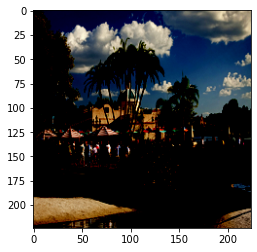

In [160]:
plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy())

## Test Stack

In [136]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/huggingface/ofa-vqa-base/'

In [137]:
tokenizer_p = OFATokenizer.from_pretrained(finetuned)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/huggingface/ofa-vqa-base/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [58]:
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


In [17]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [18]:
from core.datasets.vqa_gen_dataset import VQACollator, VqaDataset,VqaStackDataset,CLEVRVQADataset


In [19]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

In [37]:
ds_stck = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
    patch_image_size = resolution,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds_stck, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


In [38]:
ds = CLEVRVQADataset(split="valA" , patch_image_size = resolution,)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [39]:
len(ds_stck)

13409

In [40]:
for batch in stack_dl:
    break

In [41]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' are there any blocks above, the green block?', ' what color is the block to the right of the brown cube?', ' are there any gray blocks below the green cube?', ' what color is the cube above, the yellow block?', ' the cube most away from the red cube is what color?', ' what is the color of the cube that is behind the gray block?', ' the cube that is in front of the blue cube is what color?', ' what color is the block that is most away from the yellow cube?']


In [42]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'blue', 'no', 'cyan', 'blue', 'cyan', 'red', 'blue']


### Pretrained

In [43]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'blue', 'no', 'cyan', 'blue', 'cyan', 'red', 'blue']


In [44]:
gen = model_p.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

In [45]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

[' yes', ' green', ' yes', ' purple', ' purple', ' red', ' green', ' black']

In [54]:
indx = -2
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]

question:  the cube that is in front of the blue cube is what color?
pred:  green
target:  red


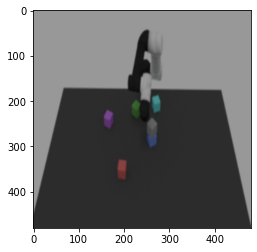

In [55]:
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

### Finetuned

In [59]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['yes', 'blue', 'no', 'cyan', 'blue', 'cyan', 'red', 'blue']


In [60]:
gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)

In [61]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['yes', 'blue', 'no', 'cyan', 'blue', 'cyan', 'red', 'blue']

question:  are there any blocks above, the green block?
pred:  yes
target:  yes


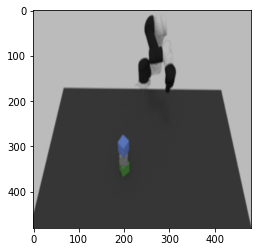

In [62]:
indx = 0
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]
plt.imshow(img)
print("question: ", tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print("pred: ",tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())
print("target: " , tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True)[indx])

## Eval script

In [63]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset, CLEVRVQADataset,LeonardoVQADataset
import itertools

In [64]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [80]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


In [ ]:
model_f.device

In [66]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images"

stack_ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds, batch_size = 10, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


In [67]:
clevr_ds = CLEVRVQADataset(split="valA")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 10, collate_fn=data_collator ,num_workers = 0, shuffle = False)


In [68]:
leonardo_ds = LeonardoVQADataset(
        data_dir = '/srv/scratch/sanisetty3/DLM/sornet/data/leonardo/',
        split="valid",
        patch_image_size=480
    )

In [69]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [71]:
from tqdm import tqdm

targets = []
pred = []
i = 0

itr = cycle(stack_dl)

for i in tqdm(range(400)):

    
    try:
        batch = next(itr)
        gen_fin = model_f.generate(batch["input_ids"].cuda(), patch_images=batch["patch_images"].cuda(), num_beams=5, no_repeat_ngram_size=3)
        pred.append(gen_fin)
        targets.append(batch["target"])
    except:
        continue
    
    
    

100%|██████████| 400/400 [19:15<00:00,  2.89s/it]


In [72]:
len(pred)

400

In [73]:
count = 0
for i in range(len(pred)):
#     print(i)
    for j in range(10):
#         print(np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2]))
        try:
            trs = int(sum(np.setdiff1d(targets[i][j],[0,1,2]) == np.setdiff1d(pred[i][j].detach().cpu().numpy(),[0,1,2])))
            count+=trs
        except:
            continue
count/(10*len(pred))

0.921

In [66]:
for i in zip(targets , pred):
    print(tokenizer_p.batch_decode(i[0], skip_special_tokens=True))
    print(tokenizer_p.batch_decode(i[1], skip_special_tokens=True))
    print("\n")

['0', '2', '1', '0', '1', 'no', 'yes', 'no', 'yes', 'yes']
['0', '1', '1', '1', '1', 'no', 'yes', 'no', 'yes', 'yes']


['gray', 'cyan', 'cyan', 'gray', 'gray', '1', '0', '0', '1', '0']
['gray', 'cyan', 'cyan', 'gray', 'gray', '0', '0', '0', '1', '0']


['no', 'no', 'yes', 'no', 'yes', 'green', 'green', 'green', 'green', 'red']
['no', 'no', 'no', 'no', 'yes', 'green', 'green', 'green', 'green', 'red']


['2', '2', '1', '2', '0', 'yes', 'no', 'no', 'yes', 'no']
['0', '1', '0', '0', '0', 'yes', 'no', 'yes', 'no', 'no']


['blue', 'blue', 'blue', 'blue', 'blue', '1', '0', '1', '0', '3']
['blue', 'blue', 'blue', 'brown', 'blue', '0', '0', '0', '0', '1']


['yes', 'yes', 'no', 'yes', 'no', 'red', 'red', 'red', 'red', 'red']
['no', 'yes', 'yes', 'yes', 'no', 'red', 'red', 'red', 'green', 'red']


['1', '0', '1', '0', '1', 'no', 'no', 'yes', 'no', 'yes']
['2', '0', '1', '0', '1', 'no', 'no', 'yes', 'yes', 'yes']


['gray', 'purple', 'gray', 'purple', 'gray', '0', '1', '0', '0', '1']
['red', '

['red', 'red', 'red', 'red', 'yes', 'no', 'yes', 'yes', 'no', 'gray']
['red', 'red', 'red', 'red', 'yes', 'no', 'yes', 'yes', 'no', 'gray']


['red', 'gray', 'gray', 'red', 'no', 'yes', 'yes', 'no', 'no', 'red']
['red', 'gray', 'gray', 'red', 'no', 'yes', 'yes', 'no', 'no', 'red']


['red', 'red', 'red', 'red', 'yes', 'no', 'no', 'yes', 'no', 'yellow']
['red', 'red', 'red', 'red', 'yes', 'no', 'no', 'yes', 'no', 'yellow']


['yellow', 'yellow', 'yellow', 'yellow', 'yes', 'yes', 'no', 'no', 'yes', 'purple']
['yellow', 'yellow', 'yellow', 'yellow', 'yes', 'yes', 'no', 'no', 'yes', 'purple']


['purple', 'purple', 'purple', 'purple', 'no', 'yes', 'no', 'yes', 'no', 'red']
['purple', 'purple', 'purple', 'purple', 'no', 'yes', 'no', 'yes', 'no', 'red']


['red', 'red', 'red', 'gray', 'yes', 'no', 'yes', 'no', 'yes', 'gray']
['gray', 'red', 'red', 'gray', 'yes', 'no', 'yes', 'no', 'no', 'gray']


['cyan', 'gray', 'gray', 'cyan', 'no', 'yes', 'no', 'no', 'yes', 'blue']
['cyan', 'gray', 'gray'

['brown', 'yellow', 'brown', 'brown', 'no', 'yes', 'yes', 'yes', 'no', 'red']


['red', 'red', 'red', 'red', 'no', 'no', 'yes', 'yes', 'yes', 'yellow']
['red', 'red', 'red', 'red', 'no', 'no', 'yes', 'yes', 'yes', 'yellow']


['yellow', 'yellow', 'yellow', 'yellow', 'yes', 'no', 'no', 'no', 'no', 'green']
['yellow', 'yellow', 'yellow', 'yellow', 'yes', 'no', 'no', 'no', 'yes', 'green']


['green', 'green', 'gray', 'gray', 'no', 'yes', 'no', 'yes', 'no', 'brown']
['green', 'green', 'gray', 'gray', 'no', 'yes', 'no', 'yes', 'no', 'brown']


['brown', 'blue', 'brown', 'brown', 'yes', 'no', 'yes', 'yes', 'yes', 'green']
['purple', 'blue', 'purple', 'brown', 'yes', 'no', 'yes', 'yes', 'yes', 'green']


['green', 'cyan', 'green', 'cyan', 'no', 'no', 'no', 'yes', 'no', 'yellow']
['green', 'cyan', 'green', 'cyan', 'no', 'no', 'no', 'yes', 'no', 'yellow']


['yellow', 'yellow', 'yellow', 'yellow', 'yes', 'no', 'yes', 'no', 'yes', 'purple']
['purple', 'purple', 'purple', 'purple', 'yes', 'no', '

['gray', 'green', 'purple', 'gray', 'yes', 'no', 'yes', 'no', 'no', 'cyan']
['gray', 'green', 'purple', 'gray', 'no', 'no', 'yes', 'no', 'no', 'cyan']


['cyan', 'red', 'cyan', 'red', 'no', 'yes', 'no', 'yes', 'no', 'cyan']
['cyan', 'red', 'cyan', 'cyan', 'no', 'yes', 'no', 'no', 'no', 'cyan']


['cyan', 'cyan', 'cyan', 'cyan', 'yes', 'no', 'yes', 'no', 'yes', 'yellow']
['cyan', 'cyan', 'red', 'cyan', 'yes', 'no', 'yes', 'no', 'yes', 'yellow']


['yellow', 'yellow', 'yellow', 'yellow', 'no', 'yes', 'yes', 'no', 'no', 'brown']
['yellow', 'yellow', 'yellow', 'yellow', 'no', 'yes', 'yes', 'yes', 'no', 'brown']


['brown', 'brown', 'brown', 'brown', 'no', 'yes', 'no', 'yes', 'no', 'green']
['brown', 'purple', 'brown', 'brown', 'no', 'yes', 'no', 'no', 'no', 'green']


['green', 'green', 'green', 'green', 'yes', 'yes', 'no', 'no', 'yes', 'purple']
['green', 'green', 'green', 'green', 'yes', 'yes', 'no', 'no', 'yes', 'purple']


['purple', 'gray', 'gray', 'purple', 'yes', 'no', 'no', 'yes', 

['red', 'red', 'red', 'brown', 'no', 'no', 'yes', 'no', 'yes', 'red']
['red', 'red', 'red', 'brown', 'yes', 'no', 'yes', 'no', 'yes', 'red']


['green', 'green', 'green', 'red', 'no', 'yes', 'no', 'yes', 'no', 'gray']
['green', 'green', 'green', 'red', 'no', 'yes', 'no', 'yes', 'no', 'gray']


['gray', 'gray', 'gray', 'gray', 'yes', 'no', 'yes', 'no', 'yes', 'red']
['gray', 'gray', 'gray', 'gray', 'yes', 'no', 'yes', 'no', 'yes', 'red']


['blue', 'blue', 'blue', 'blue', 'yes', 'no', 'no', 'yes', 'no', 'brown']
['blue', 'blue', 'blue', 'gray', 'yes', 'no', 'yes', 'no', 'no', 'brown']


['brown', 'brown', 'brown', 'brown', 'yes', 'no', 'no', 'yes', 'no', 'blue']
['red', 'brown', 'red', 'red', 'yes', 'no', 'no', 'yes', 'no', 'blue']


['blue', 'blue', 'blue', 'purple', 'yes', 'yes', 'yes', 'no', 'no', 'gray']
['blue', 'blue', 'blue', 'purple', 'yes', 'yes', 'no', 'no', 'no', 'gray']


['gray', 'gray', 'gray', 'gray', 'no', 'yes', 'no', 'yes', 'yes', 'gray']
['red', 'red', 'gray', 'red', 

In [40]:
##Val A f
count/(10*len(pred))

0.9

In [21]:
## ValB = 0.4
count/(10*len(pred))

0.0

0.0

In [211]:
count/(8*604)

0.625

### finetuned

Stack : 0.625
ClevrA : 0.90
ClevrB : 0.6


### Pretrained

valA: 0 1000



## Custom image and question

In [79]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [81]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False).cuda()
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [82]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [88]:
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images/*.png"
img_list = glob(vqa_root)

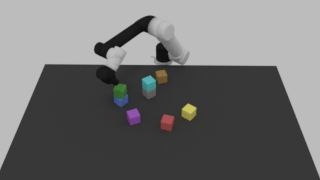

In [124]:
txt = "What color block is above the blue block?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open(img_list[30])
patch_img = patch_resize_transform(img).unsqueeze(0)
img

### Pretrained

In [125]:
custom_gen = model_p.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

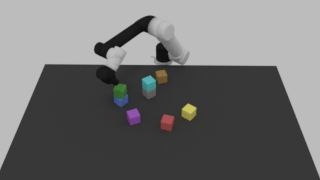

What color block is above the blue block?
white


In [126]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [127]:
custom_gen_fin = model_f.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)

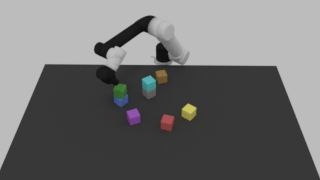

What color block is above the blue block?
green


In [128]:
display(img)
print(txt)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())

## Push to hub

In [129]:
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig

In [130]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [77]:
# fine_tuned ="/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/"
# pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny/'

tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False).cuda()
tokenizer_p = OFATokenizer.from_pretrained(finetuned)


In [134]:
# from huggingface_hub import notebook_login

# notebook_login()

In [133]:
# !transformers-cli repo create OFA-base-vqa-finetune